In [1]:
import glob
import os

import pandas as pd

Get a list of ECR csv files

In [2]:
ecr_files = glob.glob('../data/input/ecr/*.csv')

Load the ECR from CSVs, cleansing the data a bit on the way in.

In [3]:
def normalise_license_areas(series):
    return series.replace({        
        "ELECTRICITY NORTH WEST LIMITED": "ENWL",
        "Northern Powergrid (Northeast) plc": "NPG (Northern Electric)",
        "Northern Powergrid (Yorkshire) plc": "NPG (Yorkshire Electric)",
        "SCOTTISH HYDRO ELECTRIC POWER DISTRIBUTION PLC": "SPEN (SP Distribution)",
        # "": "SPEN (SP MANWEB)",
        # "": "SSE",
        "SOUTHERN ELECTRIC POWER DISTRIBUTION PLC": "SSE (Southern)",
        "Eastern Power Networks plc": "UKPN (East)",
        "London Power Networks plc": "UKPN (London)",
        "South Eastern Power Networks plc": "UKPN (South)",
        "National Grid Electricity Distribution (East Midlands) Plc": "WPD (East Midlands)",
        "National Grid Electricity Distribution (West Midlands) Plc": "WPD (Midlands)",
        "National Grid Electricity Distribution (South Wales) Plc": "WPD (South Wales)",
        "National Grid Electricity Distribution (South West) Plc": "WPD (South West)",
    })

def load_data(filename):
    '''
    Load the ECR data from a CSV, and cleanse the content
    '''
    data = pd.read_csv(filename)

    # Strip leading / trailing spaces from column titles
    data.columns = data.columns.str.strip()

    # Normalise the licence area names
    data['Licence Area'] = data["Licence Area"].pipe(normalise_license_areas)

    # Strip leading / trailing spaces from the Flexible Connection column
    # data['Flexible Connection (Yes/No)'] = data['Flexible Connection (Yes/No)'].str.strip()

    # Correct a typo in the Connection Status column
    data['Connection Status'].replace({
        'Accecpted to Connect': 'Accepted to Connect',
    }, inplace=True)

    return data

all_data = pd.concat([
    load_data(f)
    for f in 
    ecr_files
])

Now simplify the data set to extract only the columns we're interested in

In [4]:
def simplify(data):
    result = data.loc[
            :,
            [
                'Licence Area',
                'Connection Status',
                'Maximum Export Capacity (MW)',
                'Accepted to Connect Registered Capacity (MW)',
            ]
        ]
    return result

simplified_data = all_data.pipe(simplify)

Normalise the data by converting it from wide (column per variable) into long (column for variable name then column for value). This makes aggregation and filtering much easier.

In [5]:
def normalise(data: pd.DataFrame, values: list[str]):
    ids = [c for c in data.columns.values if c not in values]

    result = data.melt(
        id_vars=ids,
        value_vars=values
    )

    result = result.dropna()

    # Convert strings to numerid
    # !! May lose some data
    result.value = pd.to_numeric(result.value, errors='coerce')

    return result

data = simplified_data.pipe(normalise, values=[
    'Maximum Export Capacity (MW)',
    'Accepted to Connect Registered Capacity (MW)',
])

Calculate sums of the variables

In [6]:
sums = data.pivot_table(
    index=['Licence Area'],
    columns=['variable'],
    values=['value'],
    aggfunc='sum',
)
sums.columns = sums.columns.get_level_values(1)
sums['total_capacity'] = sums['Accepted to Connect Registered Capacity (MW)'] + sums['Maximum Export Capacity (MW)']

Plot a quick stacked bar chart

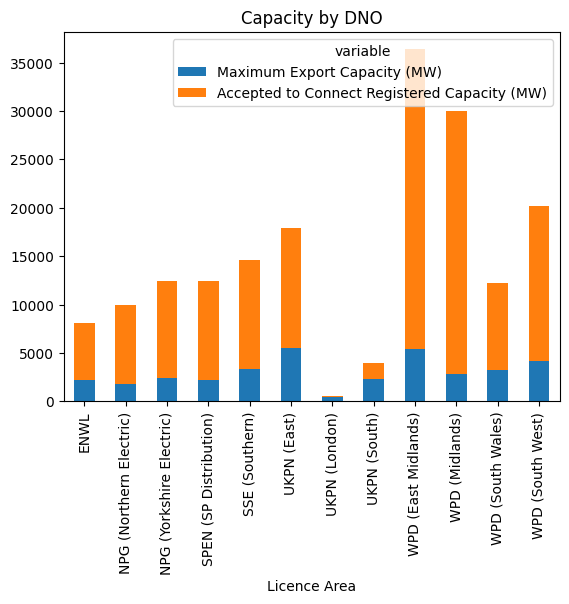

In [7]:
axes = sums.loc[:, ['Maximum Export Capacity (MW)', 'Accepted to Connect Registered Capacity (MW)']].plot.bar(stacked=True, title="Capacity by DNO")

Add in counts of ECR items by license area

In [8]:
summary = pd.concat([
    sums,
    data['Licence Area'].value_counts()
], axis=1)


Plot a quick bar chart of that

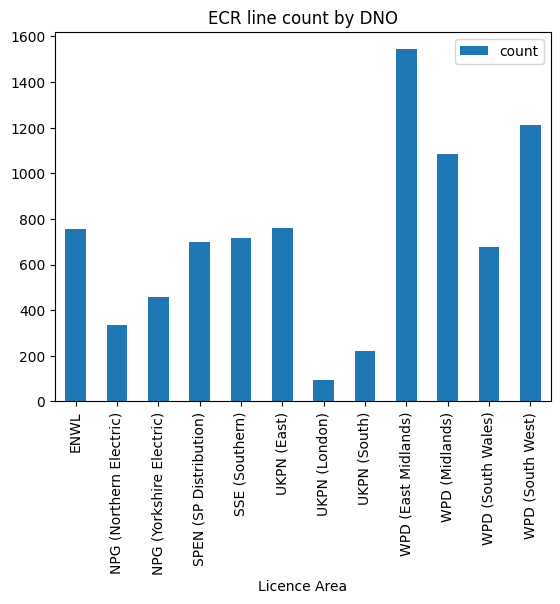

In [9]:
axes = summary.loc[:, ['count']].plot.bar(title="ECR line count by DNO")

Save the file for further processing

In [10]:
os.makedirs('../src/questions/3/_data/', exist_ok=True)
summary.to_csv('../src/questions/3/_data/ecr.csv')

In [11]:
pd.Categorical(data['Licence Area']).unique().tolist()

['SPEN (SP Distribution)',
 'SSE (Southern)',
 'WPD (East Midlands)',
 'WPD (Midlands)',
 'WPD (South Wales)',
 'WPD (South West)',
 'ENWL',
 'NPG (Northern Electric)',
 'NPG (Yorkshire Electric)',
 'UKPN (East)',
 'UKPN (London)',
 'UKPN (South)']